In [1]:
%load_ext autoreload
%autoreload 2

import json
import csv
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("utils/")
from datasets.AstDataset import AstDataset
from utils.TreeLstmUtils import batch_tree_input
from utils.TreePlotter import TreePlotter
from models.Vae import Vae
from loss_functions.TreeVaeLoss import TreeVaeLoss, TreeVaeLossComplete
from utils.TreeNode import Node
from anytree.exporter import JsonExporter
import numpy as np
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
csv.field_size_limit(sys.maxsize)

131072

In [3]:
# HYPERPARAMETERS
params = {
    'LEAF_EMBEDDING_DIM': 100,
    'EMBEDDING_DIM': 30,
    'HIDDEN_SIZE': 800,
    'LATENT_DIM': 800,
    'LEARNING_RATE': 0.005,
    'EPOCHS': 10,
    'BATCH_SIZE': 4,
    'NUM_WORKERS': 0,
    'CLIP': 5,
    'KL_LOSS_WEIGHT': 0.001,
}

def load_token_vocabulary(path):
    if os.path.isfile(path):
        # Load the reserved tokens dictionary
        with open(path, 'r') as json_f:
            json_data = json_f.read()

        # To JSON format (dictionary)
        tokens = json.loads(json_data)

    else:
        tokens = {}

        for dirpath, _, files in os.walk(path):
            for file in files:
                if file.endswith('.json'):
                    with open(os.path.join(dirpath, file), 'r') as json_f:
                        json_data = json_f.read()

                    # To JSON format (dictionary)
                    for k,v in json.loads(json_data).items():
                            if k in tokens:
                                tokens[k] += v
                            else:
                                tokens[k] = v

    return tokens


def train(dataset_path, tokens_paths=None, tokenized=False):
    token_vocabs = {}
    label_to_idx = None
    idx_to_label = None
    
    for k, path in tokens_paths.items():
        token_vocabs[k] = load_token_vocabulary(path)
        params[f'{k}_VOCAB_SIZE'] = len(token_vocabs[k])
        
    if len(tokens_paths) > 1:
        # Load loss
        vae_loss = TreeVaeLossComplete(params['KL_LOSS_WEIGHT'])
    else:       
        vae_loss = TreeVaeLoss(params['KL_LOSS_WEIGHT'])
            
    
    if not tokenized:
        label_to_idx = {}
        idx_to_label = {}
        for k, vocab in token_vocabs.items():
            label_to_idx[k] = {k:i for i, k in enumerate(vocab.keys())}
            idx_to_label[k] = {v:k for k, v in label_to_idx[k].items()}
            
    non_res_tokens = len(tokens_paths) > 1
    
    ast_dataset = AstDataset(dataset_path, label_to_idx, max_tree_size=-1, remove_non_res=not non_res_tokens)

    loader = DataLoader(ast_dataset, batch_size=params['BATCH_SIZE'], collate_fn=batch_tree_input, num_workers=params['NUM_WORKERS'])
    
    # set model
    vae = Vae(device, params)
        
    # Train
#     vae.train(loader, params['EPOCHS'], save_dir='checkpoints/')
    return vae, loader, idx_to_label, label_to_idx
    # Train
#     vae.train(loader, params['EPOCHS'])
    
tokens_paths = {
    'RES': '../data/ast_trees/reserved_tokens.json',
    'NAME': '../data/ast_trees/name_tokens.json',
    'TYPE': '../data/ast_trees/type_tokens.json',
    'LITERAL': '../data/ast_trees/literal_tokens.json',
}
dataset_path = '../data/ast_trees/asts.csv.bz2'


vae, loader, idx_to_label, label_to_idx = train(dataset_path, tokens_paths)

In [4]:
vae.load_model('checkpoints/VAE_epoch0_17-04-2021_15:48.tar')

In [5]:
for batch in loader:
    data = batch
    break

In [9]:
trees = vae.evaluate(data, idx_to_label['RES'])

exporter = JsonExporter()

df = pd.DataFrame(columns=['id', 'AST'])
for index, tree in enumerate(trees):
    ast = exporter.export(tree)
    df = df.append([{'id': index, 'AST' : ast}], ignore_index=True)
    
df.to_csv('output/asts.csv', index=False)

In [7]:
trees[0].children

(<utils.TreeNode.Node at 0x7fc5fa1f78e0>,
 <utils.TreeNode.Node at 0x7fc5fa1f7790>)

In [27]:
torch.cat([torch.empty(0), torch.tensor([[2, 3], [4, 5]])])

tensor([[2., 3.],
        [4., 5.]])

In [21]:
for batch in loader:
    data = batch
    break

In [51]:
tree = build_tree(data['adjacency_list'], data['features'])

In [32]:
exporter = JsonExporter()
exporter.export(tree)

'{"token": 0, "res": true, "children": [{"token": 2, "res": true, "children": [{"token": 3, "res": true, "children": [{"token": 0, "res": true}, {"token": 0, "res": true}]}, {"token": 4, "res": true, "children": [{"token": 2, "res": true}]}]}, {"token": 2, "res": true, "children": [{"token": 3, "res": true, "children": [{"token": 0, "res": true}, {"token": 0, "res": true}]}, {"token": 4, "res": true, "children": [{"token": 2, "res": true}]}]}, {"token": 2, "res": true, "children": [{"token": 3, "res": true, "children": [{"token": 0, "res": true}, {"token": 0, "res": true}]}, {"token": 4, "res": true, "children": [{"token": 2, "res": true}]}]}, {"token": 5, "res": true, "children": [{"token": 6, "res": true, "children": [{"token": 62, "res": true}]}, {"token": 7, "res": true, "children": [{"token": 8, "res": true, "children": [{"token": 11, "res": true}]}]}]}, {"token": 5, "res": true, "children": [{"token": 6, "res": true, "children": [{"token": 62, "res": true}, {"token": 14, "res": t

In [1]:
def load_token_vocabulary(path):
    if os.path.isfile(path):
        # Load the reserved tokens dictionary
        with open(path, 'r') as json_f:
            json_data = json_f.read()

        # To JSON format (dictionary)
        tokens = json.loads(json_data)

    else:
        tokens = {}

        for dirpath, _, files in os.walk(path):
            for file in files:
                if file.endswith('.json'):
                    with open(os.path.join(dirpath, file), 'r') as json_f:
                        json_data = json_f.read()

                    # To JSON format (dictionary)
                    for k,v in json.loads(json_data).items():
                            if k in tokens:
                                tokens[k] += v
                            else:
                                tokens[k] = v

    return tokens

In [6]:
tokens = load_token_vocabulary('../data/ast_trees_solutions600/reserved_tokens/')
tokens = dict(sorted(tokens.items(), key=lambda x:x[1], reverse=True))

In [12]:
tokens_leafs = load_token_vocabulary('../data/ast_trees_solutions600/tokens/')
tokens_leafs = dict(sorted(tokens_leafs.items(), key=lambda x:x[1], reverse=True))

In [45]:
import re
type_refs = [('ll', 'long long')]
types = [el.strip() for el in re.split('<', 'pair<ll, pair<long long, ll> >')[1].split('>')[0].split(',')]

In [46]:
types

['ll', 'pair']

In [35]:
for typ in types:
    matches = [item for item in type_refs if item[0] == typ]
    if len(matches) > 0:
        print(matches[0])

('ll', 'long long')


In [64]:
trees = pd.read_csv('../data/ast_trees/asts.csv.bz2')

In [65]:
print(trees.iloc[0][1])

{
  "token": "root",
  "res": true,
  "children": [
    {
      "token": "TYPEDEF_DECL",
      "res": true,
      "children": [
        {
          "token": "TYPE_DEF",
          "res": true,
          "children": [
            {
              "token": "TYPE_KIND",
              "res": true,
              "children": [
                {
                  "token": "TYPE",
                  "res": true,
                  "children": [
                    {
                      "token": "long long",
                      "res": false
                    }
                  ]
                }
              ]
            }
          ]
        },
        {
          "token": "IDENTIFIER",
          "res": true,
          "children": [
            {
              "token": "ll",
              "res": false
            }
          ]
        }
      ]
    },
    {
      "token": "TYPEDEF_DECL",
      "res": true,
      "children": [
        {
          "token": "TYPE_DEF",
          "res": true

In [13]:
tokens_leafs

{'i': 31827347,
 'int': 25890376,
 'long': 18038509,
 '0': 16106854,
 '1': 15929649,
 'n': 13349673,
 'a': 10066010,
 'operator<<': 7562627,
 'x': 7226008,
 'j': 7035975,
 '<': 6431762,
 '>': 6197419,
 'operator[]': 6045917,
 'operator>>': 5497929,
 'b': 5326486,
 'll': 4508242,
 'cin': 4429537,
 'cout': 4421382,
 's': 4144000,
 'ans': 3963303,
 'k': 3961537,
 '[': 3909721,
 ']': 3909299,
 '2': 3870988,
 'm': 3452776,
 '::': 3439870,
 'v': 3242932,
 'std': 3214599,
 'y': 2859375,
 ',': 2716950,
 'c': 2622521,
 'main': 2611171,
 'vector': 2599643,
 'const': 2446546,
 'p': 2323290,
 'r': 2290901,
 'l': 2263686,
 't': 2011363,
 'T': 1685724,
 'pair': 1662798,
 'endl': 1448796,
 '&': 1401756,
 'void': 1390236,
 'N': 1385845,
 'u': 1379802,
 'size': 1325908,
 'cnt': 1296733,
 'string': 1228257,
 'scanf': 1212740,
 'd': 1210295,
 'sum': 1200130,
 'q': 1132427,
 'res': 1097368,
 'tie': 1092758,
 'f': 1074405,
 'double': 1060846,
 'printf': 1057509,
 'bool': 1032033,
 'push_back': 1015712,
 'f

In [99]:
label_dict = dict((reversed(item) for item in reserved_tokens.items()))

In [27]:
print(exporter.export(tree))

{"token": 0, "res": true, "children": [{"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, "children": [{"token": 9, "res": true, "children": [{"token": 11, "res": false}]}]}]}, {"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, "children": [{"token": 9, "res": true, "children": [{"token": 11, "res": false}]}]}]}, {"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, "children": [{"token": 9, "res": true, "children": [{"token": 11, "res": false}]}]}]}, {"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, 

In [75]:
z = torch.tensor([np.random.normal(loc=0.0, scale=1.0, size=params['LATENT_DIM']) for i in range(5)], device=device).float()
z.shape

torch.Size([5, 256])

In [77]:
generated_trees = vae.generate(z)

In [84]:
TreePlotter.plot_predicted_tree(generated_trees[0], 'generated_tree.png')

In [9]:
for batch in loader:
    for key in batch.keys():
        if key != 'tree_sizes':
            batch[key] = batch[key].to(device)
            
    encoder.eval()
    decoder.eval()
    z, _, _ = encoder(batch)
    trees = decoder(z)
    break

In [41]:
idx_to_label = dict((reversed(item) for item in label_to_idx.items()))
idx_to_res_label = dict((reversed(item) for item in res_label_to_idx.items()))

In [108]:
with open('tokens.json', 'w') as f:
    f.write(json.dumps(label_to_idx))
    
with open('reserved_tokens.json', 'w') as f:
    f.write(json.dumps(res_label_to_idx))

In [3]:
trees = pd.read_csv('../data/ast_trees/asts.csv.bz2')
tree = trees.iloc[0][1]

In [24]:
from anytree.importer import JsonImporter

In [16]:
JsonImporter().import_()

TypeError: import_() takes 2 positional arguments but 3 were given

In [32]:
TreePlotter.plot_tree(trees[0], 'first_tree.png', idx_to_label, idx_to_label['RES'])

In [4]:
TreePlotter.plot_tree(tree, 'actual_tree_tree.png')
# TreePlotter.plot_tree(tree, 'actual_tree.png', label_dict)

AttributeError: 'str' object has no attribute 'res'

In [70]:
from anytree.exporter import JsonExporter
exporter = JsonExporter()
with open('test.json', 'w') as f:
    f.write(exporter.export(trees[0]))

In [86]:
decoder.eval()
trees = decoder(z)

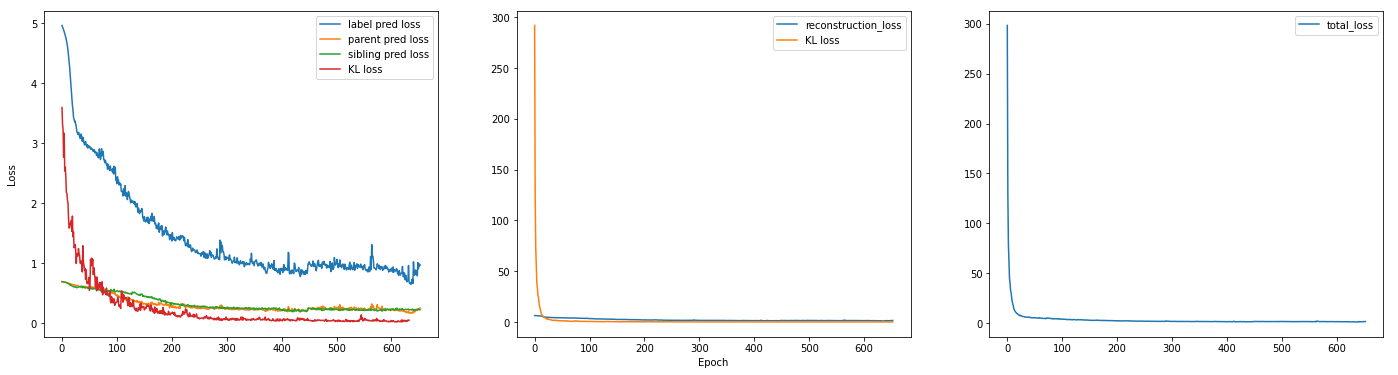

In [123]:
figure, ax = plt.subplots(1, 3, figsize=(24,6))
figure.add_subplot(111, frameon=False)

ax[0].plot(losses['label_prediction_loss'], label='label pred loss')
ax[0].plot(losses['parent_loss'], label='parent pred loss')
ax[0].plot(losses['sibling_loss'], label='sibling pred loss')
ax[0].plot(losses['kl_loss'][20:], label='KL loss')
ax[0].legend()

ax[1].plot(np.add(np.add(losses['label_prediction_loss'], losses['parent_loss']), losses['sibling_loss']), label='reconstruction_loss')
ax[1].plot(losses['kl_loss'], label='KL loss')
ax[1].legend()

ax[2].plot(losses['total_loss'], label='total_loss')
ax[2].legend()

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [150]:
parents = list(set([el.item() for el in batch['adjacency_list'][:169][:, 0]]))

In [49]:
def build_tree(adj_list, features, index=0, parent_node=None):
    node = Node(features[index].item(), parent=parent_node)
    children = adj_list[adj_list[:, 0] == index][:, 1]

    for child in children:
        build_tree(adj_list, features, child, node)

    return node
            

In [161]:
tree = build_tree(batch['adjacency_list'], batch['features'])

In [172]:
pred_tree = build_tree(batch['adjacency_list'], torch.argmax(output['predicted_labels'], dim=-1))

In [176]:
TreePlotter.plot_predicted_tree(pred_tree, 'predicted_tree.png')
TreePlotter.plot_predicted_tree(tree, 'actual_tree.png')

In [226]:
for index, (pred, true) in enumerate(zip(torch.argmax(output['predicted_labels'], dim=-1), output['labels'])):
    print(pred.item(), true.item())
    if index > 50:
        break

0 0.0
2 2.0
3 3.0
4 4.0
5 5.0
6 25.0
5 5.0
30 30.0
18 18.0
43 43.0
2 2.0
3 3.0
4 4.0
5 5.0
6 34.0
43 43.0
6 6.0
2 2.0
3 3.0
4 4.0
5 5.0
6 43.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0
2 2.0
3 3.0
4 4.0
5 5.0
6 17.0
2 15.0
5 5.0
16 16.0
11 11.0
19 19.0
2 2.0
3 3.0
4 4.0
5 5.0
2 2.0
3 3.0
4 4.0
5 5.0
19 50.0
53 24.0
17 24.0
17 17.0
17 17.0
17 17.0
11 11.0


In [221]:
for index, (pred, true) in enumerate(zip(output['predicted_is_parent'], output['is_parent'])):
    print(pred.item(), true.item())
    if index > 50:
        break

0.9997850060462952 1.0
0.9993454813957214 1.0
0.0005445647984743118 0.0
0.9997802376747131 1.0
0.0003903243341483176 0.0
0.32433581352233887 1.0
0.0016980406362563372 0.0
0.8883258104324341 1.0
0.8576392531394958 1.0
0.014596741646528244 0.0
0.9996651411056519 1.0
0.0005445647984743118 0.0
0.9997802376747131 1.0
0.0003903243341483176 0.0
0.32433581352233887 1.0
0.1037544310092926 0.0
0.0025435499846935272 0.0
0.9996651411056519 1.0
0.0005445647984743118 0.0
0.9997802376747131 1.0
0.0003903243341483176 0.0
0.32433581352233887 0.0
0.9996651411056519 1.0
0.0005445647984743118 0.0
0.9997802376747131 1.0
0.0003903243341483176 0.0
0.32433581352233887 0.0
0.9996651411056519 1.0
0.0005445647984743118 0.0
0.9997802376747131 1.0
0.0003903243341483176 0.0
0.32433581352233887 0.0
0.9996651411056519 1.0
0.04661606252193451 0.0
0.0007113214815035462 0.0
0.9885280132293701 1.0
0.9675545692443848 1.0
0.9997628331184387 1.0
0.00014878938964102417 0.0
0.9999227523803711 1.0
0.00018493508105166256 0.0
0.

In [167]:
batch['adjacency_list']

tensor([[    0,     1],
        [    1,     2],
        [    1,     3],
        ...,
        [16335, 16338],
        [16338, 16339],
        [16339, 16340]], device='cuda:0')

In [168]:
batch['features']

tensor([[ 0.],
        [69.],
        [70.],
        ...,
        [11.],
        [25.],
        [ 5.]], device='cuda:0')

In [145]:
batch['adjacency_list'][:169][:, 0]

tensor([  0,   1,   1,   0,   4,   4,   4,   7,   7,   9,   4,  11,  11,  13,
          4,  15,  16,  17,  18,  18,  20,  21,  21,  23,  24,  24,  26,  26,
         20,   0,  30,  30,  32,  32,  34,  34,   0,  37,  37,  37,  40,  40,
         42,  37,  44,  44,  46,  37,  48,  49,  50,  50,  49,  53,  54,  48,
         56,   0,  58,  58,  58,  61,  62,  63,  63,  65,  61,  67,  67,  61,
         70,  71,  71,  73,  70,  75,  75,  77,  61,  79,  80,  80,  79,  61,
         84,  85,  85,  87,  84,  89,  89,  91,  61,  93,  94,  94,  93,  61,
         98,  99,  99, 101,  98, 103, 103, 105,  61, 107, 108, 108, 107,  61,
        112, 113, 113, 115, 115, 117, 118, 119, 120, 120, 122, 122, 119, 125,
        125, 127, 127, 118, 130, 131, 131, 133, 133, 130, 136, 136, 138, 138,
         61,  61, 142, 143, 143, 143,   0, 147, 147, 147, 150, 151, 151, 153,
        151, 150, 156, 157, 157, 159, 159, 150, 162, 163, 162, 165, 166, 165,
        165], device='cuda:0')

In [140]:
batch['features'][:170]

tensor([[ 0.],
        [69.],
        [70.],
        [70.],
        [71.],
        [ 5.],
        [16.],
        [26.],
        [ 3.],
        [ 4.],
        [ 5.],
        [26.],
        [ 3.],
        [ 4.],
        [ 5.],
        [11.],
        [23.],
        [57.],
        [25.],
        [ 5.],
        [30.],
        [25.],
        [ 5.],
        [30.],
        [25.],
        [ 5.],
        [30.],
        [17.],
        [17.],
        [43.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [34.],
        [43.],
        [ 6.],
        [15.],
        [ 5.],
        [16.],
        [26.],
        [ 3.],
        [ 4.],
        [ 5.],
        [26.],
        [ 3.],
        [ 4.],
        [ 5.],
        [11.],
        [27.],
        [55.],
        [17.],
        [17.],
        [11.],
        [23.],
        [ 6.],
        [23.],
        [ 6.],
        [15.],
        [ 5.],
        [16.],
        [11.],
        [19.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 

In [136]:
for index, (lab, feat) in enumerate(zip(output['labels'], batch['features'])):
    print(lab, feat)
    if index > 100:
        break

tensor(0., device='cuda:0') tensor([0.], device='cuda:0')
tensor(69., device='cuda:0') tensor([69.], device='cuda:0')
tensor(70., device='cuda:0') tensor([70.], device='cuda:0')
tensor(70., device='cuda:0') tensor([70.], device='cuda:0')
tensor(71., device='cuda:0') tensor([71.], device='cuda:0')
tensor(5., device='cuda:0') tensor([5.], device='cuda:0')
tensor(16., device='cuda:0') tensor([16.], device='cuda:0')
tensor(26., device='cuda:0') tensor([26.], device='cuda:0')
tensor(3., device='cuda:0') tensor([3.], device='cuda:0')
tensor(4., device='cuda:0') tensor([4.], device='cuda:0')
tensor(5., device='cuda:0') tensor([5.], device='cuda:0')
tensor(26., device='cuda:0') tensor([26.], device='cuda:0')
tensor(3., device='cuda:0') tensor([3.], device='cuda:0')
tensor(4., device='cuda:0') tensor([4.], device='cuda:0')
tensor(5., device='cuda:0') tensor([5.], device='cuda:0')
tensor(11., device='cuda:0') tensor([11.], device='cuda:0')
tensor(23., device='cuda:0') tensor([23.], device='cuda:

In [133]:
batch['features']

tensor([[ 0.],
        [69.],
        [70.],
        ...,
        [11.],
        [25.],
        [ 5.]], device='cuda:0')

In [124]:
for index, (pred, true) in enumerate(zip(torch.argmax(output['predicted_labels'], dim=-1), output['labels'])):
    print(pred.item(), true.item())
    
    if index > 500:
        break

17 0.0
15 69.0
70 70.0
70 70.0
71 71.0
5 5.0
16 16.0
26 26.0
3 3.0
4 4.0
5 5.0
26 26.0
3 3.0
4 4.0
5 5.0
26 11.0
19 23.0
6 57.0
25 25.0
5 5.0
30 30.0
17 25.0
5 5.0
30 30.0
17 25.0
5 5.0
30 30.0
17 17.0
17 17.0
31 43.0
69 2.0
3 3.0
4 4.0
5 5.0
6 34.0
43 43.0
6 6.0
2 15.0
5 5.0
16 16.0
11 26.0
3 3.0
4 4.0
5 5.0
11 26.0
3 3.0
4 4.0
5 5.0
11 11.0
19 27.0
49 55.0
17 17.0
6 17.0
11 11.0
23 23.0
6 6.0
27 23.0
6 6.0
15 15.0
5 5.0
16 16.0
11 11.0
19 19.0
2 2.0
3 3.0
4 4.0
5 5.0
24 24.0
17 17.0
17 17.0
50 19.0
2 2.0
3 3.0
4 4.0
5 5.0
2 2.0
3 3.0
4 4.0
5 5.0
24 24.0
17 24.0
24 17.0
17 17.0
17 17.0
50 19.0
2 2.0
3 3.0
4 4.0
5 5.0
2 2.0
3 3.0
4 4.0
5 5.0
24 24.0
17 24.0
24 17.0
17 17.0
17 17.0
50 19.0
2 2.0
3 3.0
4 4.0
5 5.0
2 2.0
3 3.0
4 4.0
5 5.0
24 24.0
17 24.0
24 17.0
17 17.0
17 17.0
50 19.0
2 2.0
3 3.0
4 4.0
5 5.0
6 57.0
6 28.0
28 49.0
17 25.0
5 5.0
30 30.0
17 17.0
17 17.0
6 25.0
5 5.0
30 30.0
17 17.0
17 17.0
11 49.0
17 25.0
5 5.0
30 30.0
17 17.0
17 17.0
6 25.0
5 5.0
30 30.0
17 17.0
17 17.0
24

tensor([ 0.,  2.,  3.,  ..., 17., 23.,  6.], device='cuda:0')

In [ ]:
for batch in loader:
    break

z, _, _ = encoder(batch)

In [120]:
for batch in tqdm(loader, position=0):
    if batch['tree_sizes'][0] < 30:
        data = batch
        break
        
for key in data.keys():
        if key != 'tree_sizes':
            data[key] = data[key].to(device)

encoder.train()
decoder.train()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
vae_loss = VaeLoss()

pbar = tqdm(unit='batch', position=0)
for i in range(1000):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
            
    z, z_mean, z_log_var = encoder(data)
    reconstructed_tree, output = decoder(z, data)
    
    loss = vae_loss(output, z_mean, z_log_var, len(reserved_tokens))
    loss.backward()    
    encoder_optimizer.step()
    decoder_optimizer.step()
    pbar.set_postfix(loss=round(loss.item(), 3))
    pbar.update()
#     tree = retrieve_tree(batch['features'], batch['adjacency_list'], 0)

{'total_loss': [tensor(161.2562, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(79.3005, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(47.3698, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(40.6093, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(26.8318, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(25.8960, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(20.6566, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(17.4204, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(17.9077, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(15.7321, device='cuda:0', grad_fn=<AddBackward0>)],
 'label_prediction_loss': [tensor(4.9460, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(4.9242, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(4.9006, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(4.8806, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(4.8529, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(4.8278, device='cuda:0', grad_fn=<NllLos

In [ ]:
TreePlotter.plot_predicted_tree(reconstructed_tree[0], 'predicted_tree.png')

In [7]:
reader = csv.reader(open('../data/ast_trees/asts.csv.bz2'))

next(reader)

TreePlotter.plot_tree(JsonImporter().import_(next(reader)[1]), 'first_tree.png')


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 10: invalid start byte

In [ ]:
        trees = []
        offset = 0
        counter = TreeNodeCounter()
                
        # Build tree by tree in batch
        for index, z in enumerate(inp_batch):
            # Initialize hidden_parent values
            hidden_parent = (z.unsqueeze(0), torch.zeros(self.latent_size).unsqueeze(0).to(device))
          
            if self.training:
                tree_size = target['tree_sizes'][index]
                
                adjacency_list_tree = batch['adjacency_list'][(batch['adjacency_list'][:,0] >= offset) & (batch['adjacency_list'][:,0] < offset + tree_size)]
                                
                tree, counter = self.build_tree(hidden_parent, None, output, None, counter, target['features'], adjacency_list_tree, node_index=offset)
                offset += tree_size
            else:
                tree, counter = self.build_tree(hidden_parent, None, output, None, counter)
                
            trees.append(tree)
            counter.increase()
                            
        return trees, output
            
        
    def build_tree(self, hidden_parent, hidden_sibling, output, parent_node=None, index=0,
                   features=None, adjacency_list=None, siblings=[], node_index=0):
                
        # Split hidden parent, into state and cell
        hidden_state_parent, hidden_cell_parent = hidden_parent      
        # Run hidden parent state through U_parent
        U_parent = self.U_parent(hidden_state_parent)
        
        # If there was a previous sibling, calculate U_sibling, otherwise use 0 to not include this value
        if hidden_sibling is not None:
            hidden_state_sibling, hidden_cell_sibling = hidden_sibling
            U_sibling = self.U_sibling(hidden_state_sibling)
        else:
            U_sibling = 0
        
        # tanh(U_parent + U_sibling)
        h_pred = torch.tanh(U_parent + U_sibling)
        label_pred = self.label_prediction(h_pred)
        
        # Probability of the node having children
        p_parent = self.sigmoid(self.depth_pred(h_pred))
        # Probability of the node having successor children
        p_sibling = self.sigmoid(self.width_pred(h_pred))
        
        # Teacher forcing on is_parent, has_sibling
        if self.training:
            label, child_indices = self.get_truth_values(features, adjacency_list, node_index)
            is_parent = torch.tensor([1], device=device, dtype=torch.float32) if len(child_indices) > 0 else torch.tensor([0], device=device, dtype=torch.float32)
            has_sibling = torch.tensor([1], device=device, dtype=torch.float32) if len(siblings) > 1 else torch.tensor([0], device=device, dtype=torch.float32)
        else:
            # Sample is_parent and has_sibling from predicted probability of parent/sibling
            is_parent = torch.distributions.bernoulli.Bernoulli(p_parent).sample()
            has_sibling = torch.distributions.bernoulli.Bernoulli(p_sibling).sample()
            
            # Could also simply use > 0.5 instead OR TODO BEAM SEARCH
            # is_parent = torch.tensor(1) if p_parent > 0.5 else torch.tensor(0)
            # has_sibling = torch.tensor(1) if p_sibling > 0.5 else torch.tensor(0)
            
        
        # Node label prediction
        predicted_label = self.softmax(label_pred + self.offset_parent(is_parent) + self.offset_sibling(has_sibling))
        
        # Build tree: Add node to tree
        if parent_node is None:
            node = Node(torch.argmax(predicted_label, dim=-1), parent=None)
        else:
            node = Node(torch.argmax(predicted_label, dim=-1), parent=parent_node)
            
        # For computing loss, save output (predictions and true values)
        output['predicted_labels'][index.get()] = predicted_label
        output['labels'][index.get()] = label
        output['predicted_has_siblings'][index.get()] = p_sibling
        output['has_siblings'][index.get()] = has_sibling
        output['predicted_is_parent'][index.get()] = p_parent
        output['is_parent'][index.get()] = is_parent
            
        
        # Teacher forcing on label
        if self.training:
            label = F.one_hot(label.long(), self.vocab_size).float()
        else:
            label = predicted_label
            
        
        if has_sibling:
            index.increase()
            if hidden_sibling is not None:
                hidden_sibling = self.lstm_sibling(label, hidden_sibling)
            else:
                hidden_sibling = self.lstm_sibling(label)
            
            if self.training:
                siblings.pop(0)
                self.build_tree(hidden_parent, hidden_sibling, output, parent_node, index, features, adjacency_list, siblings, siblings[0])
                
            else:
                self.build_tree(hidden_parent, hidden_sibling, output, parent_node, index)
            
        if is_parent:
            index.increase()
            hidden_parent = self.lstm_parent(label, hidden_parent)
            parent_node = node
            
            if self.training:
                siblings = list(child_indices)
                self.build_tree(hidden_parent, None, output, parent_node, index, features, adjacency_list, siblings, siblings[0])
                
            else:
                self.build_tree(hidden_parent, None, output, parent_node, index)
                
        return parent_node, index
        
        
    def get_truth_values(self, features, adjacency_list, index):
        adjacency_list_current = adjacency_list[adjacency_list[:, 0] == index]

        x = features[index, :]
        child_indices = adjacency_list_current[:, 1]

        return x, child_indices
    
    
class TreeNodeCounter:
    def __init__(self):
        self.counter = 0
        
    def increase(self):
        self.counter += 1
    
    def get(self):
        return self.counter
    
    def reset(self):
        self.counter = 0